In [7]:
## Import
import numpy as np
import matplotlib.pyplot as plt

In [8]:
## Create Theta Sampled
R = 2
Fs = 128
omega_not = (2*np.pi)*(R+2)
t_sampled = np.arange(0, 1, 1/Fs)
theta_sampled = (omega_not*t_sampled)%(2*np.pi)
# Caution ! Floating point errors
theta_sampled[theta_sampled<1e-10]=0
theta_sampled[theta_sampled>(2*np.pi - 1e-10)]=0
print(theta_sampled.shape)

(128,)


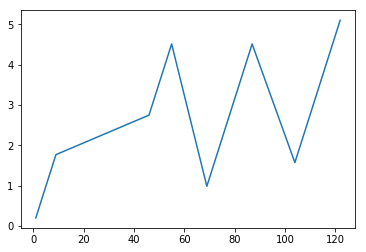

In [9]:
## Set Random Seed
np.random.seed(R+2)
n_train = 10
n_test = Fs-n_train
# Train Indices and Thetas
indices = np.array([k for k in range(Fs)])
train_indices = np.sort(np.random.choice(indices, n_train))
train_thetas = theta_sampled[train_indices]
# Test Indices and Thetas
test_indices = np.sort(np.array([index for index in indices if index not in train_indices]))
test_thetas = theta_sampled[test_indices]
# Plot
plt.plot(train_indices, train_thetas)

In [11]:
M = 10

# Create a N*(M+1) shaped numpy matrix from given indices
def create_X(n_indices, M) :
    X=[]
    for n in n_indices :
        X_n = [(n/Fs)**i for i in range(0, M+1)]
        X.append(X_n)
    return np.array(X)

X_train = create_X(train_indices, M)
X_test = create_X(test_indices, M)

# Create the N*1 shaped numpy array from given thetas
def create_Y(thetas) : 
    Y = np.reshape(thetas.T, list(thetas.T.shape)+[1])
    return Y
    
Y_train = create_Y(train_thetas)
Y_test = create_Y(test_thetas)

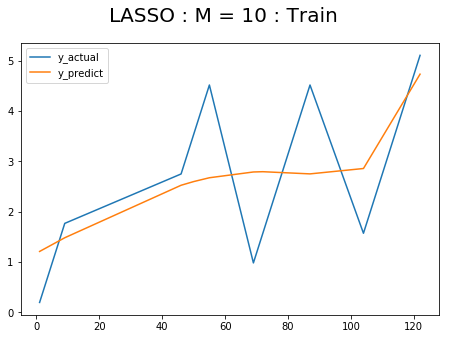

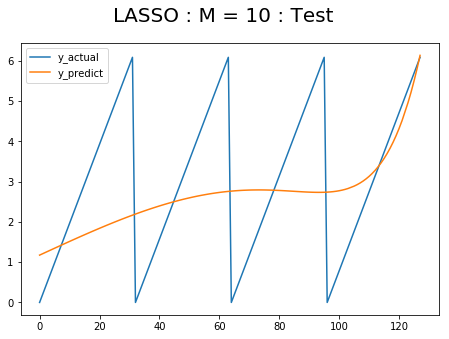

In [12]:
## LASSO
def reconstruction_error(X, Y, Weights) :
    Y_hat = np.dot(X, Weights)
    Error = np.mean(np.square(Y-Y_hat)/2)
    return Error   

def Signum(Weights) :
    Signum_Weights = np.copy(Weights)
    Signum_Weights[Signum_Weights>0]=1
    Signum_Weights[Signum_Weights<0]=-1
    return Signum_Weights

def LASSO(X, Y, Weights, Lambda = 0, step_size=1e-2, iterations=1000000, threshold=1e-5) :
    N = Y.shape[0]
    for t in range(iterations) :
        Y_hat = np.dot(X, Weights)
        Gradients = -np.dot(X.T, (Y-Y_hat))/N  + Lambda*Signum(Weights)    # Gradients of shape (M+1)*1
        Error = np.linalg.norm(step_size*Gradients)
        if(Error<threshold) : break
        Weights = Weights - step_size*Gradients
    return Weights

# Run Gradient Descent on train set
LASSO_Weights = np.ones((M+1, 1))
LASSO_Weights = LASSO(X_train, Y_train, LASSO_Weights, Lambda = 0.01)
Y_hat_train = np.dot(X_train, LASSO_Weights)
Y_hat_test = np.dot(X_test, LASSO_Weights)

# Plot Y_hat_train vs train_indices

figure = plt.figure(figsize=(7.5, 5))
figure.suptitle('LASSO : M = ' + str(M) + ' : Train', fontsize=20)
plt.plot(train_indices, Y_train)
plt.plot(train_indices, Y_hat_train)
plt.gca().legend(('y_actual', 'y_predict'))
# figure.savefig('LASSO_' + str(M) + '_Train.pdf', bbox_inches='tight')

# Plot Y_test vs test_indices

figure = plt.figure(figsize=(7.5, 5))
figure.suptitle('LASSO : M = ' + str(M) + ' : Test', fontsize=20)

plt.plot(test_indices, Y_test)
plt.plot(test_indices, Y_hat_test)

plt.gca().legend(('y_actual', 'y_predict'))
# figure.savefig('LASSO_' + str(M) + '_Test.pdf', bbox_inches='tight')

In [ ]:
Lambdas = []
Errors = []
Weights = []

# Run LASSO on train set
for Lambda in np.arange(0, 0.1, 0.01) : 
    # Create the Weights and Y_hat_test
    LASSO_Weights = LASSO(X_train, Y_train, np.ones((M+1, 1)), Lambda)
    Y_hat_test = np.dot(X_test, LASSO_Weights)
    
    # Store Reconstruction_Error and Weights versus Lambda
    Lambdas.append(Lambda)
    Errors.append(reconstruction_error(X_test, Y_test, LASSO_Weights))
    Weights.append(LASSO_Weights)

# Convert to numpy arrays
Lambdas = np.array(Lambdas)
Errors = np.array(Errors)
Weights = np.array(Weights) 

In [ ]:
# Plot Errors and Weights vs Lambda
figure = plt.figure(figsize=(7.5, 5))
figure.suptitle("Reconstruction Error" , fontsize=20)
plt.plot(Lambdas, Errors)
plt.xlabel('Lambda', fontsize=10)
plt.ylabel('Error', fontsize=10)
plt.figure()
# figure.savefig("error.pdf", bbox_inches='tight')

In [ ]:
# Plot Weights vs Lambda
figure = plt.figure(figsize=(7.5, 5))
figure.suptitle("LASSO Weights" , fontsize=20)
for k in range(Weights[:, :, 0].shape[1]) :
    plt.plot(Lambdas, Weights[:, k, 0])
    plt.xlabel('Lambda', fontsize=10)
    plt.ylabel('Weight', fontsize=10)
# figure.savefig("plots.pdf", bbox_inches='tight')